# Методы анализа и обработки изображения - Коррекция яркости и цвета 

In [1]:
from skimage.io import imread, imshow, imsave
from skimage import img_as_uint, img_as_ubyte, img_as_float
from numpy import histogram, clip, average
import numpy as np

In [2]:
import matplotlib.pyplot as plt
def compare_img(img1, img2, label1 = '', label2 = ''):
    fig = plt.figure(figsize=(10, 10))
    
    fig.add_subplot(1, 2, 1)
    imshow(img1)
    plt.axis('off')
    plt.title(label1)
    
    fig.add_subplot(1, 2, 2)
    imshow(img2)
    plt.axis('off')
    plt.title(label2)
    
    plt.show()

In [3]:
def show_img(img, label = ''):
    imshow(img)
    plt.axis('off')
    plt.title(label)
    
def save_img(img, filename):
    imsave(filename, img)

In [4]:
imgTiger_bw = imread('tiger-low-contrast.png') 
#ORIGINAL URL: https://stepik.org/media/attachments/lesson/58402/tiger-low-contrast.png

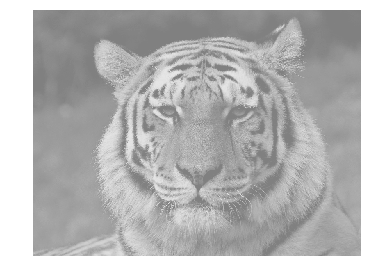

In [5]:
show_img(imgTiger_bw)

## Автоконтраст

In [6]:
def linear_stretching(x, Xmin, Xmax, isFloat = False):
    stretched = ((x - Xmin) * (1 if isFloat else 255) / (Xmax - Xmin)).astype('uint8')
    return clip(stretched, 0, 1 if isFloat else 255)

In [7]:
def autocontrast(original_img):
    img = original_img.copy()
    
    img = img.astype('float')
    
    color_min = min(img.ravel())
    color_max = max(img.ravel())

    return linear_stretching(img, color_min, color_max).astype('uint8')

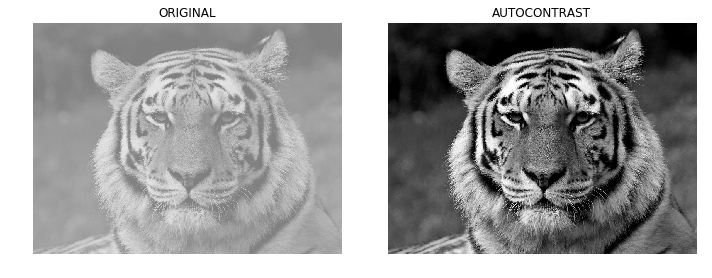

In [8]:
compare_img(imgTiger_bw, autocontrast(imgTiger_bw), 'ORIGINAL', 'AUTOCONTRAST')

Доработка функции автоконтраста

### Устойчивый автоконтраст

In [9]:
def stable_autocontrast(original_img):
    
    img = original_img.copy().astype(float)

    k = round(img.shape[0]*img.shape[1]*0.05)

    img_sort = img.copy().ravel()
    img_sort.sort()

    color_min = img_sort[k]
    color_max = img_sort[len(img_sort) - k]

    img = (img - color_min) * 255 / (color_max - color_min)
    img = clip(img, 0, 255)
    
    return img.astype('uint8')

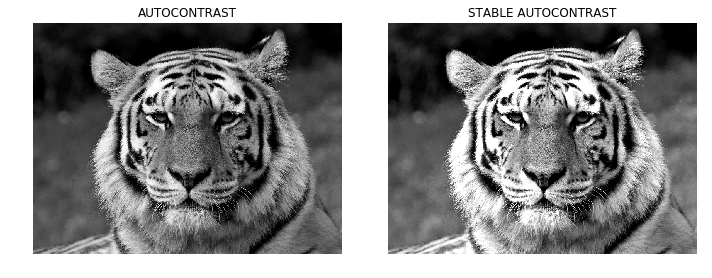

In [10]:
compare_img(autocontrast(imgTiger_bw), stable_autocontrast(imgTiger_bw), 'AUTOCONTRAST', 'STABLE AUTOCONTRAST')

## Коррекция контраста цветного изображения

In [11]:
imgTiger = imread('tiger-color.png')
# ORIGINAL URL: https://stepik.org/media/attachments/lesson/60609/tiger-color.png

In [12]:
from numpy import dstack

def stack_img(red, green, blue):
    return dstack((red, green, blue))

In [13]:
def rgb_to_channels(img):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    return R, G, B

In [14]:
def rgb_to_yuv(R, G, B):
    Y = 0.2126 * R + 0.7152 * G + 0.0722 * B
    U = -0.0999 * R - 0.3360 * G + 0.4360 * B
    V = 0.6150 * R - 0.5586 * G - 0.0563 * B
    
    return Y, U, V

def yuv_to_rgb(Y, U, V):
    
    R = Y + 1.2803 * V
    G = Y - 0.2148 * U - 0.3805 * V
    B = Y + 2.1279 * U
    
    return R, G, B

In [15]:
def linear_stretching_yuv(Y, Xmax, Xmin):
    Y_modify = (Y - Xmin) * 255 / (Xmax - Xmin)
    return clip(Y_modify, 0, 255)

### Устойчивый автоконтраст цветного изображения

In [16]:
def color_autocontrast(image_original):
    img = image_original.copy()
    img = img.astype('float')
    
    R, G, B = rgb_to_channels(img)
    
    Y, U, V = rgb_to_yuv(R, G, B)
    
    k = round(img.shape[0]*img.shape[1]*0.05)
    
    Y_sort = Y.copy().ravel()
    Y_sort.sort()
    
    Xmin = Y_sort[k]
    Xmax = Y_sort[len(Y_sort) - k]
    
    Y_modify = linear_stretching_yuv(Y, Xmax, Xmin)
    
    R_contrast, G_contrast, B_contrast = yuv_to_rgb(Y_modify, U, V)
    
    img_contrast = stack_img(R_contrast, G_contrast, B_contrast)
    
    img_contrast = clip(img_contrast,0,255)
    
    return img_contrast.astype('uint8')

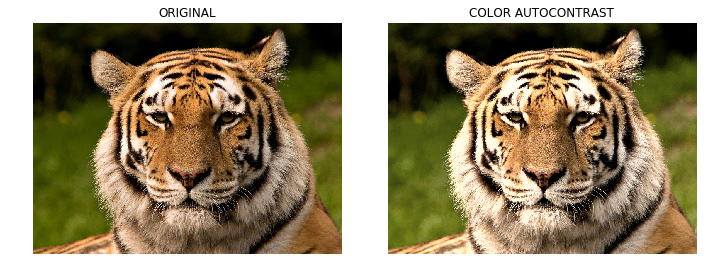

In [17]:
compare_img(imgTiger, color_autocontrast(imgTiger), 'ORIGINAL', 'COLOR AUTOCONTRAST')

## Баланс белого

In [18]:
imgRailroad = imread('railroad.png')
# ORIGINAL URL: https://stepik.org/media/attachments/lesson/60610/railroad.png

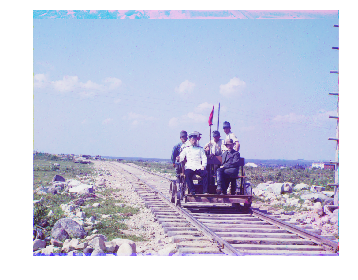

In [19]:
show_img(imgRailroad)

In [20]:
def white_balance(image_original):
    img = image_original.copy()
    img = img.astype('float')
    
    R, G, B = rgb_to_channels(img)
    
    R_ravel = R.ravel()
    G_ravel = G.ravel()
    B_ravel = B.ravel()
    
    avg=(average(R_ravel)+average(G_ravel)+average(B_ravel))/3
    
    Rw = average(R_ravel)/avg
    Gw = average(G_ravel)/avg
    Bw = average(B_ravel)/avg
    
    R = R/Rw
    G = G/Gw
    B = B/Bw
    
    img_balanced = stack_img(R, G, B)
    img_balanced = clip(img_balanced, 0, 255)
    
    return img_balanced.astype('uint8')

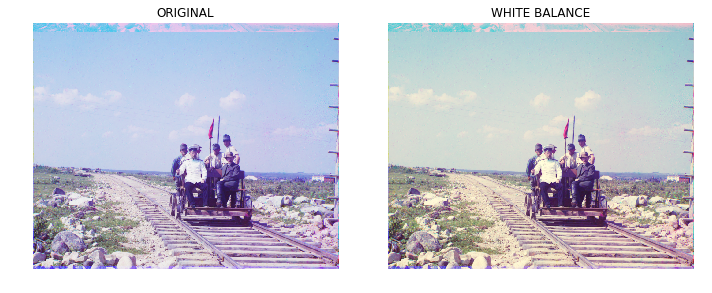

In [21]:
compare_img(imgRailroad, white_balance(imgRailroad), 'ORIGINAL', 'WHITE BALANCE')

## Выравнивание гистограммы

In [22]:
imgLandscape = imread('landscape.png')
# ORIGINAL URL: https://stepik.org/media/attachments/lesson/60611/landscape.png

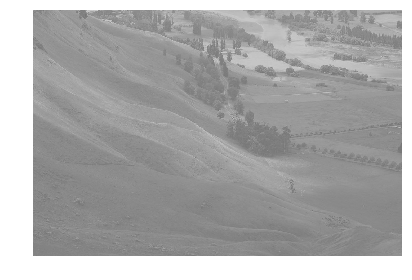

In [23]:
show_img(imgLandscape)

In [24]:
def make_histogram(img):
    hist = np.zeros(256,np.int32)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            value = img[i][j]
            hist[value] += 1
    
    return hist

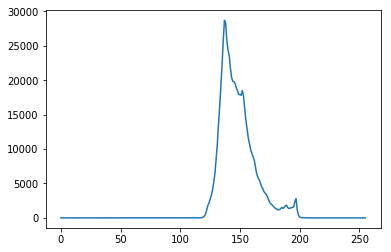

In [25]:
landscape_hist = make_histogram(imgLandscape)
plt.plot(landscape_hist)
plt.show()

In [26]:
def make_cdf(hist):
    cdf = np.zeros(256,np.int32)
    for i in range(256):
        cdf[i] = sum(hist[0:i])
        
    return cdf

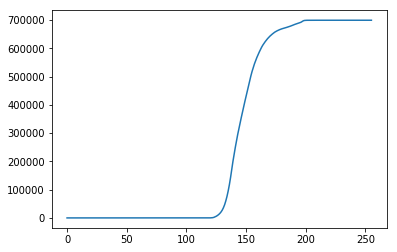

In [27]:
landscape_hist_cdf = make_cdf(landscape_hist)
plt.plot(landscape_hist_cdf)
plt.show()

In [28]:
def correct_cdf(cdf, img):
    height = img.shape[0]
    width = img.shape[1]
    hist = np.zeros((height,width))
    cdf_min = min(cdf > 0)

    for i in range(height):
        for j in range(width):
            x = img[i][j]
            hist[i][j] = round((cdf[x] - cdf_min)/(height * width - 1) * 255)
            
    return hist

def hist_correction(img):
    cdf = make_cdf(make_histogram(img))
    
    img_corrected = correct_cdf(cdf, img)
    img_corrected = clip(img_corrected, 0, 255)
    
    return img_corrected.astype('uint8')

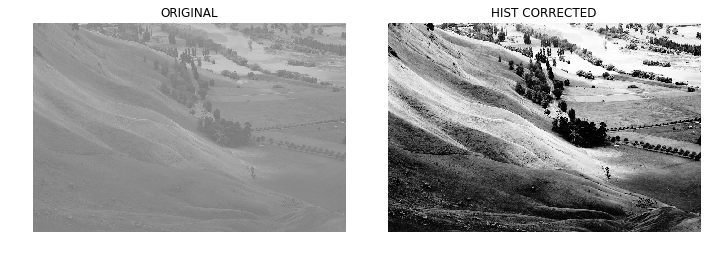

In [30]:
compare_img(imgLandscape, hist_correction(imgLandscape), 'ORIGINAL', 'HIST CORRECTED')

---

Студенты гр. РИМ-181226

Бабайлова Маргарита Леонидовна

Кабанов Евгений Алексеевич